# XML example and exercise
****
+ study examples of accessing nodes in XML tree structure  
+ work on exercise to be completed and submitted
****
+ reference: https://docs.python.org/2.7/library/xml.etree.elementtree.html
+ data source: http://www.dbis.informatik.uni-goettingen.de/Mondial
****

In [1]:
from xml.etree import ElementTree as ET

## XML example

+ for details about tree traversal and iterators, see https://docs.python.org/2.7/library/xml.etree.elementtree.html

In [2]:
document_tree = ET.parse( './data/mondial_database_less.xml' )

In [3]:
# print names of all countries
for child in document_tree.getroot():
    print child.find('name').text

Albania
Greece
Macedonia
Serbia
Montenegro
Kosovo
Andorra


In [4]:
# print names of all countries and their cities
for element in document_tree.iterfind('country'):
    print '* ' + element.find('name').text + ':',
    capitals_string = ''
    for subelement in element.getiterator('city'):
        capitals_string += subelement.find('name').text + ', '
    print capitals_string[:-2]

* Albania: Tirana, Shkodër, Durrës, Vlorë, Elbasan, Korçë
* Greece: Komotini, Kavala, Athina, Peiraias, Peristeri, Acharnes, Patra, Kozani, Kerkyra, Ioannina, Thessaloniki, Iraklio, Chania, Ermoupoli, Rhodes, Tripoli, Lamia, Chalkida, Larissa, Volos, Mytilini, Karyes
* Macedonia: Skopje, Kumanovo
* Serbia: Beograd, Novi Sad, Niš
* Montenegro: Podgorica
* Kosovo: Prishtine
* Andorra: Andorra la Vella


****
## XML exercise

Using data in 'data/mondial_database.xml', the examples above, and refering to https://docs.python.org/2.7/library/xml.etree.elementtree.html, find

1. 10 countries with the lowest infant mortality rates
2. 10 cities with the largest population
3. 10 ethnic groups with the largest overall populations (sum of best/latest estimates over all countries)
4. name and country of a) longest river, b) largest lake and c) airport at highest elevation

In [5]:
document = ET.parse( './data/mondial_database.xml' )

## Q1: 10 countries with the lowest infant mortality rates
We read the relevant data from the xml file to pandas data frames. We start with the infant mortality rates for each country. In particular, we read the name and the infant mortality of each country in the data into lists, and generate data frames using these lists.

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd

In [7]:
countries = []
infant_mortality = []
for element in document.iterfind('country'):
    countries.append(element.find('name').text)
    # In case of missing infant mortality data, fill with NaN
    im = element.find('infant_mortality')
    im = float(im.text) if im is not None else np.nan
    infant_mortality.append(im)
df = pd.DataFrame({'country': countries, 'infant_mortality': infant_mortality})
df.sort_values(by='infant_mortality', ascending=True).head(10)

,country,infant_mortality
38,Monaco,1.81
98,Japan,2.13
117,Bermuda,2.48
36,Norway,2.48
106,Singapore,2.53
37,Sweden,2.60
10,Czech Republic,2.63
78,Hong Kong,2.73
79,Macao,3.13
44,Iceland,3.15


## Q2: 10 cities with the largest population
Similarly, we read in the population of each city into a pandas data frame to process. One caveat here is that the data contains population estimates of different years (for countries and for cities as well), we would like to use the latest estimate.

In [8]:
cities = []
population = []
for city in document.iter('city'):
    cities.append(city.find('name').text)
    # Use the latest population estimate. In case of missing data, fill with NaN
    pop = np.nan
    ref_year = 0
    for p in city.findall('population'):
        # update population if it is a later estimate
        if p.get('year') > ref_year:
            pop = float(p.text)
    population.append(pop)

df = pd.DataFrame({'city': cities, 'population': population})
df.sort_values(by='population', ascending=False).head(10)

,city,population
1341,Shanghai,22315474.0
771,Istanbul,13710512.0
1527,Mumbai,12442373.0
479,Moskva,11979529.0
1340,Beijing,11716620.0
2810,São Paulo,11152344.0
1342,Tianjin,11090314.0
1064,Guangzhou,11071424.0
1582,Delhi,11034555.0
1067,Shenzhen,10358381.0


We may use bar plots to visualize the population differences of the top 20 cities in population.

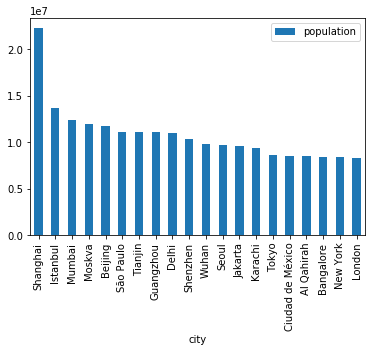

In [9]:
df.sort_values(by='population', ascending=False).head(20).plot(x='city',y='population',kind='bar')

## Q3: 10 ethnic groups with the largest overall populations
Since each ethnic group may be spreading in several countries, we need to read the ethnic groups, the percentage, as well as the total population of each country. Based on this data, we may compute the population of each ethnic group in each country. It then remains to sum up the population across countries for each ethnic group.

In [10]:
countries = []
populations = []
ethnics = []
percentages = []
for element in document.iterfind('country'):
    country = element.find('name').text
    # Use the latest population estimate. In case of missing data, fill with NaN
    pop = np.nan
    ref_year = 0
    for p in element.findall('population'):
        # update population if it is a later estimate
        if p.get('year') > ref_year:
            pop = float(p.text)
    
    # Insert a row for each ethnic group in a country
    for e in element.findall('ethnicgroup'):
        countries.append(country)
        populations.append(pop)
        ethnics.append(e.text)
        percentages.append(float(e.get('percentage')))

df = pd.DataFrame({'country': countries, 'population': populations, 'ethnic': ethnics, 'percentage':percentages})
df['ethnic_population'] = df.percentage * df.population / 100

ethnic_population = df.groupby('ethnic')['ethnic_population'].sum()
ethnic_population.sort_values(ascending=False).head(10)

ethnic
Han Chinese    1.245059e+09
Indo-Aryan     8.718156e+08
European       4.948722e+08
African        3.183251e+08
Dravidian      3.027137e+08
Mestizo        1.577344e+08
Bengali        1.467769e+08
Russian        1.318570e+08
Japanese       1.265342e+08
Malay          1.219936e+08
Name: ethnic_population, dtype: float64

## Q4
Since the countries only appear in forms of codes in the landscape data, we first construct a data frame with the country names and codes for later use.

In [11]:
countries = []
country_codes = []
# Read country name and code into lists
for country in document.iterfind('country'):
    countries.append(country.find('name').text)
    country_codes.append(country.get('car_code'))
df_country = pd.DataFrame({'country': countries, 'country_code': country_codes})
df_country.head()

,country,country_code
0,Albania,AL
1,Greece,GR
2,Macedonia,MK
3,Serbia,SRB
4,Montenegro,MNE


### Name and country of the longest river

In [12]:
rivers = []
country_codes = []
lengths = []
for r in document.iterfind('river'):
    rivers.append(r.find('name').text)
    # Note that each river may be in more than one country
    country_codes.append(r.get('country').split())
    l = r.find('length')
    l = float(l.text) if l is not None else np.nan
    lengths.append(l)
    
df_river = pd.DataFrame({'river': rivers, 'country_code': country_codes, 'length': lengths})
# Get the longest river
c = df_river.sort_values(by='length', ascending=False).head(1)
# Print out facts about the longest river
print "The longest river is: " + c.river.iloc[0]
print "The longest river has length: " + str(c.length.iloc[0]) + " (km)"
# Print countries according to the country table
countries_list = df_country.country[df_country.country_code.isin(c.country_code.iloc[0])].tolist()
countries_string = ', '.join(countries_list)
print "The longest river is in the following country(ies): " + countries_string

The longest river is: Amazonas
The longest river has length: 6448.0 (km)
The longest river is in the following country(ies): Colombia, Brazil, Peru


### Name and country of the largest lake

In [13]:
lakes = []
country_codes = []
areas = []
for l in document.iterfind('lake'):
    lakes.append(l.find('name').text)
    # Note that each lake may be in more than one country
    country_codes.append(l.get('country').split())
    area = l.find('area')
    area = float(area.text) if area is not None else np.nan
    areas.append(area)
    
df_lake = pd.DataFrame({'lake': lakes, 'country_code': country_codes, 'area': areas})
# Get the largest lake
c = df_lake.sort_values(by='area', ascending=False).head(1)
# Print out facts about the largest lake
print "The largest lake is: " + c.lake.iloc[0]
print "The largest lake has area: " + str(c.area.iloc[0])
# Print countries according to the country table
countries_list = df_country.country[df_country.country_code.isin(c.country_code.iloc[0])].tolist()
countries_string = ', '.join(countries_list)
print "The largest lake is in the following country(ies): " + countries_string 

The largest lake is: Caspian Sea
The largest lake has area: 386400.0
The largest lake is in the following country(ies): Russia, Iran, Turkmenistan, Azerbaijan, Kazakhstan


### Name and country of the airport at the highest elevation

In [14]:
airports = []
country_codes = []
elevations = []
for airport in document.iterfind('airport'):
    airports.append(airport.find('name').text)
    country_codes.append(airport.get('country'))
    e = airport.find('elevation')
    elevation = float(e.text) if e is not None and e.text is not None else np.nan
    elevations.append(elevation)
    
df_airport = pd.DataFrame({'airport': airports, 'country_code': country_codes, 'elevation': elevations})
c = df_airport.sort_values(by='elevation', ascending=False).head(1)
print "The airport at the highest elevation is: " + c.airport.iloc[0]
print "The elevation of the highest airport is: " + str(c.elevation.iloc[0]) + " (km)"
# Print the country according to the country table
print "The airport at the highest elevation is in: " + df_country.country[df_country.country_code == c.country_code.iloc[0]].iloc[0]

The airport at the highest elevation is: El Alto Intl
The elevation of the highest airport is: 4063.0 (km)
The airport at the highest elevation is in: Bolivia
